<a href="https://colab.research.google.com/github/mb1te/SMPR/blob/main/SMPR_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**0. Загрузка датасета**

In [ ]:
import seaborn as sns
df = sns.load_dataset('iris')
X = df[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']]
y = df[['species']]

**Метод потенциальных функций**

Поместим центр парзеновского окна не в классифицируемый объект, а в каждый объект обучающей выборки.

Алгоритм классификации объекта:

$X^l -- обучающая выборка, x -- класифицируемый объект.$

1) Для каждого объекта задается ширина окна $h_i$ и подбирается сила потенциала $\gamma_i$.

2) Вес объекта $w_i = \gamma_i * K(\frac{\rho(x_i, x)}{h_i})$.

3) Просуммируем веса объектов одинаковых классов. Классифицируем наш объект по классу с наибольшим суммарным весом.

\\

Алгоритм подбора $\gamma_i$:

1)Для каждого объекта мы добавляем потенциал, определяющий его влияние на результат.

2) Пока ошибок $> eps$ мы находим объекты, которые классифицируются неверно и увеличиваем их потенциал на $1$.

3) Величина потенциала была ограничена сверху значением $3$, чтобы они бесконечно не возрастали на шумовых объектах.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

"""
Классификатор, реализующий метод парзеновского окна
"""
class PotentialFunctionClassifier:
  """
  Конструктор класса
  x -- pandas.DataFrame с признаками
  y -- pandas.Series с метками классов
  K -- функция, реализующая ядро
  h -- размер окна

  Сохраняет в класс признаки с метками, их длину, 
  запускает обучение модели.
  """
  def __init__(self, X, y, h, K):
    self._X = X
    self._y = y
    self._h = h
    self._K = K
    self._size = len(X)

    self._train()

  """
  Статический метод, реализующий евклидово расстояния
  a, b -- numpy.Array, содержащий координаты объекта 
  """
  @staticmethod
  def _distance(a, b):
    return np.sqrt(np.sum((a - b)**2))

  """
  Метод обучения модели, вызывает метод, подбирающий потенциалы
  """
  def _train(self, eps=0):
    self._tune_gammas()
  """
  Метод подбора потенциалов.
  eps -- максимально допустимое число ошибок на выборке
  Изначально все потенциалы равны 0.
  Пока ошибок  > eps  мы находим объекты, которые классифицируются неверно 
  и увеличиваем их потенциал на  1 .
  """
  def _tune_gammas(self):
    self._g = [0] * self._size
    error_count = self._size
    while error_count > eps:
      cnt = 0
      for xi in range(self._size):
        pred_label = self.predict(pd.DataFrame([self._X.iloc[xi]])).values[0]
        real_label = self._y.iloc[xi].values[0]
        # print(real_label, pred_label)
        if pred_label != real_label and self._g[xi] < 3:
          cnt += 1
          self._g[xi] += 1
      error_count = cnt
      #print(cnt)

  """
  Метод predict предсказывает метки классов для новых объектов.
  x_pred - pandas.DataFrame с признаками новых объектов.
  По каждом объекту считается вес для каждой метки. Находится 
  метка класс с максимальным значением веса.
  Возвращается pandas.Series с предсказанными метками.
  """
  def predict(self, x_pred):
    predicted = []
    # print(x_pred)
    for obj in x_pred.values:
      label_counter = {}
      for xi in range(self._size):
        cur_label = self._y.iloc[xi].values[0]
        if cur_label not in label_counter:
          label_counter[cur_label] = 0
        d = self._distance(obj, self._X.iloc[xi].values)
        label_counter[cur_label] += self._g[xi] * self._K(d / self._h)
      label = max(label_counter, key=label_counter.get)
      if label_counter[label] > 10**(-3):
        predicted.append(label)
      else:
        predicted.append(-1)
    return pd.Series(predicted)

Ниже реализованы функции для построения карты классификации и визуализации смысла потенциалов

In [ ]:
from matplotlib.patches import Rectangle, Patch, Circle
from matplotlib.markers import MarkerStyle
import pandas as pd
"""
Функция, визуализирующая смысл потенциалов.
h -- ширина окна
K -- функция ядра
i -- признак по оси OX
j -- признак по оси OY

Выбирается 5% от выборки, на них обучается модель.
Рисуется график с самими объектами и потенциалами.
Потенциалы представлены в виде полупрозрачных кругов
соответствующих цветов.
"""
def draw_potentials(h, K, i='sepal_length', j='sepal_width'):
  cur_X = X[[i, j]].sample(frac=0.05)
  cur_y = y.iloc[cur_X.index]
  PWC = PotentialFunctionClassifier(cur_X, cur_y, h, K)
  color = {'virginica': 'blue', 'versicolor': 'red', 'setosa': 'green'}
  fig, ax = plt.subplots()

  for ind in range(len(cur_X)):
    xi = cur_X[i].values[ind]
    yi = cur_X[j].values[ind]
    r = PWC._g[ind]
    clr = color[cur_y.values[ind][0]]
    plt.scatter(xi, yi, color=clr)

    if r:
      c = Circle((xi, yi), radius=r,color=clr,alpha=0.1)
      ax.add_artist(c)

  plt.legend(handles=[Patch(color=color[key], label=key) for key in color])

  plt.xlim(cur_X[i].min() - 2, cur_X[i].max() + 2)
  plt.ylim(cur_X[j].min() - 2, cur_X[j].max() + 2)
  plt.show()


"""
Функция построения карты классификации с потенциалами.
K -- ядро для парзеновского окна
h -- ширина окна
i -- признак по оси OX
j -- признак по оси OY

Функция формирует карты классификации с шагом 0.1
Объекты обучающей выборка представлены закрашенными кругами,
остальная область - незакрашенными.
"""
def draw_classification_map(h, K, i='sepal_length', j='sepal_width'):
  PWC = PotentialFunctionClassifier(X[[i, j]], y, h, K)
  color = {'virginica': 'blue', 'versicolor': 'red', 'setosa': 'green'}
  fig, ax = plt.subplots()
  
  for xi in np.arange(X[i].min(), X[i].max(), 0.1):
    for yi in np.arange(X[j].min(), X[j].max(), 0.1):
      cat = PWC.predict(pd.DataFrame([(xi, yi)]))
      if cat.values[0] != -1:
        plt.scatter(xi, yi, color='none', 
                  edgecolor=color[cat.values[0]])
  
  for ind in range(len(X)):
    xi = X[i].values[ind]
    yi = X[j].values[ind]
    cat = y.values[ind][0]
    clr = color[cat]
    plt.scatter(xi, yi, color=clr)

  plt.legend(handles=[Patch(color=color[key], label=key) for key in color])

  plt.xlim(X[i].min(), X[i].max())
  plt.ylim(X[j].min(), X[j].max())
  plt.show()


Ниже представлено 5 ядер для парзеновского окна:

Прямоугольное ядро: $K(z) = \frac{1}{2}[|z| < 1]$

Треугольное ядро: $K(z) = (1 - |z|) \cdot [|z| < 1]$

Ядро Епанечкина: $K(z) = \frac{3}{4} (1 - z^2) \cdot [|z| < 1]$

Квартическое ядро: $K(z) = \frac{15}{16} (1 - z^2)^2 \cdot [|z| < 1]$

Гауссов ядро: $K(z) = \frac{1}{\sqrt{2\pi}} e^{-\frac{1}{2}z^2}$

In [ ]:
import math
kernels = [
           ('Прямоугольное ядро', 0.7, lambda z: 1/2 * (abs(z) < 1)),
           ('Треугольное ядро', 1.1, lambda z: (1 - abs(z)) * (abs(z) < 1)),
           ('Ядро Епанечкина', 0.8, lambda z: 3/4 * (1 - z**2) * (abs(z) < 1)),
           ('Квартическое ядро', 0.7, lambda z: 15/16 * (1 - z**2)**2 * (abs(z) < 1)),
           ('Гауссово ядро', 0.4, lambda z: 1/(2 * math.pi)**.5 * math.exp(-.5 * z**2))
]


Модель запускается на 5 ядрах. Для каждого ядра выводится визуализация некоторых потенциалов и карта классификации

Прямоугольное ядро
Пример потенциалов:


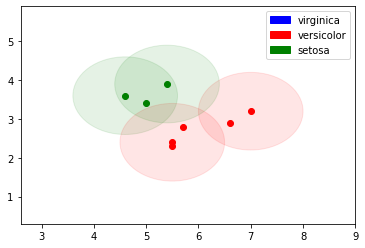

Карта классификации:


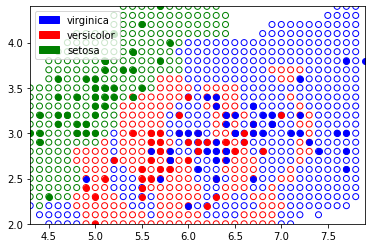

Треугольное ядро
Пример потенциалов:


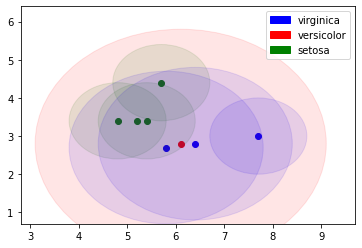

Карта классификации:


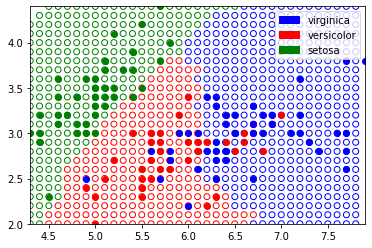

Ядро Епанечкина
Пример потенциалов:


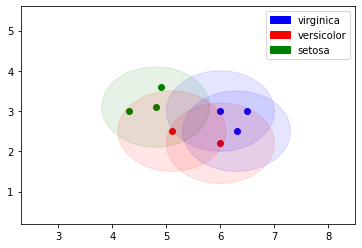

Карта классификации:


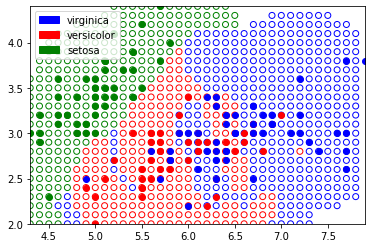

Квартическое ядро
Пример потенциалов:


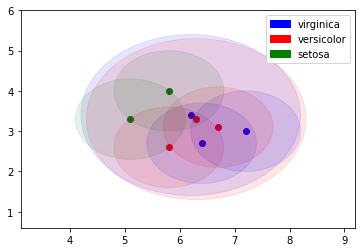

Карта классификации:


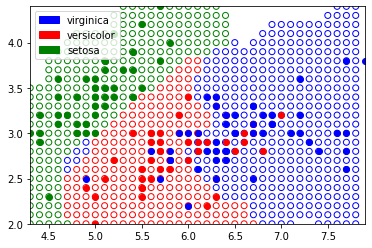

Гауссово ядро
Пример потенциалов:


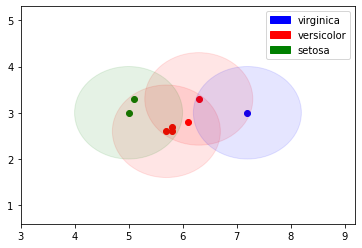

Карта классификации:


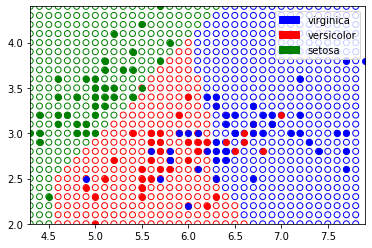

In [ ]:
for name, h, K in kernels:
  print(name)
  print('Пример потенциалов:')
  draw_potentials(h, K)
  print('Карта классификации:')
  draw_classification_map(h, K)

Результаты для разных ядер сравнимы. Все ядра смогли обучиться таким образом, чтобы не ошибаться на обучающей выборке. Прежде рассмотернные модели не смогли достичь. Связываю это с малым размером выборки, что позволило модели переобучиться на ней.

Но метод потенциальных функций унаследовал главный недостаток парзеновского окна. Для некоторых ядер невозможно классифицировать новый, если в окно не попадет ни один объект из выборки.